In [1]:
#%xmode Verbose

In [2]:
import sys
sys.path.append("../libs/")
sys.path.append("../../../deep-belief-network/")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from utils import shift_join_data, mae,rmse,mape,print_line, plot_pred, flatten
from dbn.models import SupervisedDBNRegression
import datetime

In [4]:
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
res_name = 'resultados/DBN_'+fecha_hora
n_iter = 30

In [5]:
# Parametros obtenidos por optimizacion
rbm_layers = 2
rbm_nodes = 112
h_layers_structure = [rbm_nodes for _ in range(rbm_layers)]
activation = 'tanh'
dropout = 0.2
rbm_learning_rate = 1e-4
bp_learning_rate = 1e-2
n_epochs = 20
n_iter_backprop = 200
mini_batch = 32

# Carga de datos

In [6]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

Paises

In [7]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [9]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]
df_test = df.copy()


Países de Entrenamiento

In [10]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features de Entrenamiento

In [11]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


# Normalizar

In [12]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-3,3)
df_y_train.iloc[:,:] = np.clip(df_y_train,-3,3)
df_x_test.iloc[:,:] = np.clip(df_x_test,-3,3)
df_y_test.iloc[:,:] = np.clip(df_y_test,-3,3)

# Generar variables lag y horizonte

In [13]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)
x_test, y_test = x_test[- int(len(x_test)*0.3):], y_test[- int(len(y_test)*0.3):]
x_train = flatten(x_train)
x_test = flatten(x_test)

# Entrenamiento y evaluación

In [14]:
def evaluar_dbn(x_train : np.ndarray, y_train : np.ndarray, x_test : np.ndarray,
        y_test : np.ndarray, n_iter : int, scaler : StandardScaler):
    n_splits = 5    # Nro de K Folds para CV
    res_path = res_name+'.csv'
    tscv = TimeSeriesSplit(n_splits = n_splits)
    print_line("mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3\n",res_path)
    # Inicio
    print('Inicio de evaluacion:')
    for i in range(n_iter):
        val_mae = list()
        val_rmse = list()
        val_mape = list()
        for train_idx, _ in tscv.split(x_train):
            # CV split
            x_t, y_t = x_train[train_idx], y_train[train_idx]
            # Entrenamiento
            model = SupervisedDBNRegression(
                        hidden_layers_structure = h_layers_structure,
                        learning_rate_rbm = rbm_learning_rate,
                        learning_rate = bp_learning_rate,
                        n_epochs_rbm = n_epochs,
                        n_iter_backprop = n_iter_backprop,
                        batch_size = mini_batch,
                        activation_function = activation,
                        dropout_p = dropout,
                        verbose = False)
            model.fit(x_t, y_t)
            # Prediccion
            y_pred = model.predict(x_test)
            # Denormalizando
            dn_y_test = scaler.inverse_transform(y_test)
            dn_y_pred = scaler.inverse_transform(y_pred)
            # Evaluacion
            val_mae.append(mae(dn_y_test, dn_y_pred))
            val_rmse.append(rmse(dn_y_test, dn_y_pred))
            val_mape.append(mape(dn_y_test, dn_y_pred))
        # Promedios
        mean_mae = np.mean(val_mae,axis=0)
        mean_rmse = np.mean(val_rmse,axis=0)
        mean_mape = np.mean(val_mape,axis=0)
        print_line('{},{},{},{},{},{},{},{},{}\n'.format(mean_mae[0],mean_mae[1],mean_mae[2],
            mean_rmse[0],mean_rmse[1],mean_rmse[2],mean_mape[0],mean_mape[1],mean_mape[2]),res_path)
        print('Iter: {}/{} completado.'.format(i+1,n_iter))
    print('Fin de evaluacion.')

In [15]:
# evaluar
evaluar_dbn(x_train, y_train, x_test, y_test,n_iter,std_scaler_y_test)

Inicio de evaluacion:
Iter: 1/30 completado.
Iter: 2/30 completado.
Iter: 3/30 completado.
Iter: 4/30 completado.
Iter: 5/30 completado.
Iter: 6/30 completado.
Iter: 7/30 completado.
Iter: 8/30 completado.
Iter: 9/30 completado.
Iter: 10/30 completado.
Iter: 11/30 completado.
Iter: 12/30 completado.
Iter: 13/30 completado.
Iter: 14/30 completado.
Iter: 15/30 completado.
Iter: 16/30 completado.
Iter: 17/30 completado.
Iter: 18/30 completado.
Iter: 19/30 completado.
Iter: 20/30 completado.
Iter: 21/30 completado.
Iter: 22/30 completado.
Iter: 23/30 completado.
Iter: 24/30 completado.
Iter: 25/30 completado.
Iter: 26/30 completado.
Iter: 27/30 completado.
Iter: 28/30 completado.
Iter: 29/30 completado.
Iter: 30/30 completado.
Fin de evaluacion.


# Resultados

In [16]:
df_res = pd.read_csv(res_name+'.csv')

In [17]:
df_res.describe()

,mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.851883,2.663878,2.870867,2.304226,3.098255,4.142978,69.974745,85.685497,52.640341
std,0.047597,0.058198,0.050603,0.044393,0.049367,0.039541,1.580578,2.200356,1.612678
min,1.763167,2.547250,2.783711,2.220637,2.996118,4.058653,66.818304,80.321267,49.742364
25%,1.824323,2.626661,2.830693,2.272546,3.065823,4.121441,69.076212,84.351340,51.244872
50%,1.847168,2.674527,2.869084,2.305289,3.098672,4.153123,70.053206,85.949460,52.412453
75%,1.892450,2.701822,2.912235,2.334440,3.131911,4.169734,71.274670,87.049695,54.131650
max,1.926632,2.779617,2.961548,2.372106,3.215466,4.211938,72.683884,89.945518,55.507909


<AxesSubplot:>

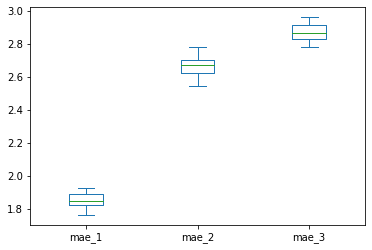

In [18]:
df_res[['mae_1','mae_2','mae_3']].plot.box()

<AxesSubplot:>

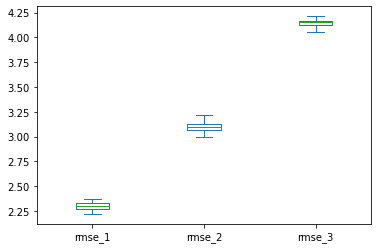

In [19]:
df_res[['rmse_1','rmse_2','rmse_3']].plot.box()

<AxesSubplot:>

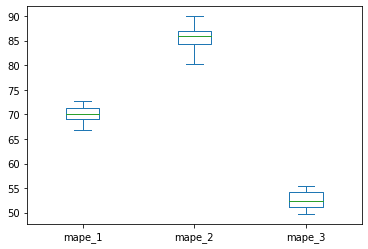

In [20]:
df_res[['mape_1','mape_2','mape_3']].plot.box()

# Prediccion

In [21]:
model = SupervisedDBNRegression(
            hidden_layers_structure = h_layers_structure,
            learning_rate_rbm = rbm_learning_rate,
            learning_rate = bp_learning_rate,
            n_epochs_rbm = n_epochs,
            n_iter_backprop = n_iter_backprop,
            batch_size = mini_batch,
            activation_function = activation,
            dropout_p = dropout,
            verbose = False)
history = model.fit(x_train, y_train)
#model.save(res_name+'.h5')

In [22]:
y_pred = model.predict(x_test)
dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

(3, 12)


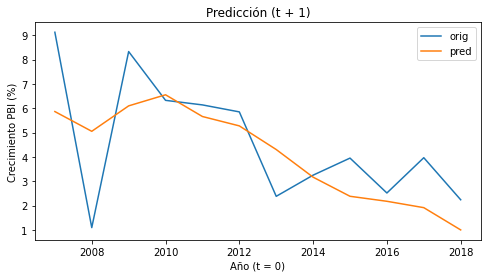

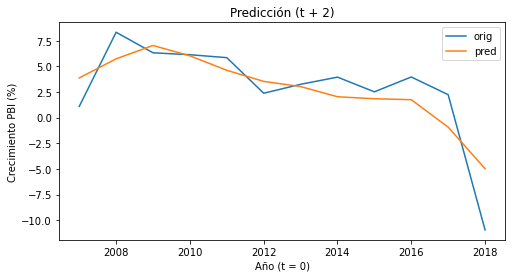

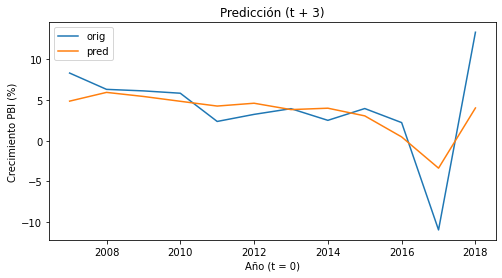

In [23]:
plot_pred(dn_y_test, dn_y_pred,2021)

In [24]:
# from notifications import enviar_correo
# enviar_correo("Evaluacion Finalizado!","Se ha completado: {}".format(res_name))